In [1]:
# -- Import
import logging
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn.objects as so
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}

from winnow.calibration.calibration_features import (
    PrositFeatures, MassErrorFeature, BeamFeatures, ChimericFeatures,
    RetentionTimeFeature
)
from winnow.calibration.calibrator import ProbabilityCalibrator
from winnow.datasets.calibration_dataset import RESIDUE_MASSES, CalibrationDataset

from winnow.datasets.psm_dataset import PSMDataset
from winnow.fdr.database_grounded import DatabaseGroundedFDRControl
from winnow.fdr.bayes import EmpiricalBayesFDRControl

In [2]:
# -- Set up logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [3]:
# -- Load data
SPECIES = 'hela_qc'
PREDICTIONS_PATH = Path(f'../winnow_data/validation/{SPECIES}_labelled_kpreds.csv')
BEAM_PREDICTIONS_PATH = Path(f'../winnow_data/validation/beam/{SPECIES}')
SPECTRUM_PATH = Path(f'../winnow_data/validation_datasets/{SPECIES}_remapped.ipc')

logger.info('Loading dataset.')
dataset = CalibrationDataset.from_predictions_csv(
    beam_predictions_path=BEAM_PREDICTIONS_PATH,
    spectrum_path=SPECTRUM_PATH,
    predictions_path=PREDICTIONS_PATH
)

# PREDICTIONS_PATH = '/home/amandlamabona/Resources/Predictions/casanovo/s_brodae.mztab'
# MGF_PATH = Path('/home/amandlamabona/Resources/Data/validation_datasets/mgf/20230608_EV_EVO_KK_FAIMS_2CV_Endurance_30SPD_1475_Sbrodae.mgf')
# LABELLED_PATH = Path('/home/amandlamabona/Resources/Data/validation_datasets/s_brodae_remapped.ipc')

# logger.info('Loading dataset.')
# dataset = CalibrationDataset.from_predictions_mztab(
#     mgf_path=MGF_PATH,
#     labelled_path=LABELLED_PATH,
#     predictions_path=PREDICTIONS_PATH
# )


# PREDICTIONS_PATH = Path('/home/amandlamabona/Resources/Predictions/pointnovo_predictions/yeast_predictions.tsv')
# MGF_PATH = Path('/home/amandlamabona/Resources/Predictions/pointnovo_predictions/yeast.mgf')

# logger.info('Loading dataset.')
# dataset = CalibrationDataset.from_pointnovo_predictions(
#     mgf_path=MGF_PATH,
#     predictions_path=PREDICTIONS_PATH
# )


# TODO: use separate dataset
# evaluation_dataset = CalibrationDataset.from_predictions_csv(
#     beam_predictions_path=BEAM_PREDICTIONS_PATH,
#     spectrum_path=SPECTRUM_PATH,
#     predictions_path=PREDICTIONS_PATH
# )

logger.info('Filtering dataset.')
# TODO: confirm only low confidence identifications
filtered_dataset = dataset.filter(
    metadata_predicate=lambda row: not isinstance(row['prediction'], list),
).filter(
    metadata_predicate=lambda row: 'N(+.98)' in row['prediction'],
).filter(
    metadata_predicate=lambda row: 'Q(+.98)' in row['prediction'],
).filter(
    metadata_predicate=lambda row: not row['prediction']
)

TEST_FRACTION = 0.2
RANDOM_STATE = 42
train, test = train_test_split(
    filtered_dataset, test_size=TEST_FRACTION, random_state=RANDOM_STATE
)

train_metadata, train_predictions = zip(*train)
train_dataset = CalibrationDataset(
    metadata=pd.DataFrame(train_metadata).reset_index(drop=True),
    predictions=list(train_predictions)
)

test_metadata, test_predictions = zip(*test)
test_dataset = CalibrationDataset(
    metadata=pd.DataFrame(test_metadata).reset_index(drop=True),
    predictions=list(test_predictions)
)

Loading dataset.
Filtering dataset.


In [4]:
# -- Set up calibrator
logger.info('Initializing calibrator.')
SEED = 42
calibrator = ProbabilityCalibrator(SEED)

logger.info('Adding features to calibrator.')
MZ_TOLERANCE = 0.02
HIDDEN_DIM = 10
TRAIN_FRACTION = 0.1
calibrator.add_feature(MassErrorFeature(residue_masses=RESIDUE_MASSES))
calibrator.add_feature(PrositFeatures(mz_tolerance=MZ_TOLERANCE))
calibrator.add_feature(
    RetentionTimeFeature(
        hidden_dim=HIDDEN_DIM, train_fraction=TRAIN_FRACTION
    )
)
# calibrator.add_feature(ChimericFeatures(mz_tolerance=MZ_TOLERANCE))
# calibrator.add_feature(BeamFeatures())

Initializing calibrator.
Adding features to calibrator.


In [5]:
len(test_dataset)

3536

In [6]:
# -- Calibrate
logger.info('Calibrating scores.')
calibrator.fit(train_dataset)
calibrator.predict(test_dataset)

Calibrating scores.


Prosit_2020_intensity_HCD::   0%|          | 0/15 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/2 [00:00<?, ?it/s]

/home/j-daniel/Repos/winnow/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Prosit_2019_irt::   0%|          | 0/15 [00:00<?, ?it/s]

Prosit_2020_intensity_HCD::   0%|          | 0/4 [00:00<?, ?it/s]

Prosit_2019_irt::   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
train_dataset.to_csv(path=f"../calibrated_datasets/{SPECIES}_train_dataset.csv")
train_dataset.metadata

,spectrum_index,global_index,peptide,prediction,confidence,local_index,Sequence,modified_sequence,precursor_mz,precursor_charge,...,num_matches,correct,Mass Error,prosit_mz,prosit_intensity,ion_matches,ion_match_intensity,iRT,predicted iRT,iRT error
0,15369,22360,"[T, A, W, I, D, G, K]","[T, A, W, I, G, D, K]",2.235249e-01,15719,TAWLDGK,_TAWLDGK_,395.70767,2,...,4,False,-0.001337,"[147.11280822753906, 173.09207153320312, 262.1...","[0.05900090932846069, 0.4022091031074524, 0.04...",0.818182,0.116867,32.305664,48.309721,16.004057
1,34357,7255,"[D, K, I, E, S, E, M, E, D, A, Y, H, E, H, Q, ...","[G, D, K, I, E, S, E, M, E, N, Y, H, E, H, G, ...",1.752217e-07,5246,DKLESEMEDAYHEHQANLLRQDLMR,_DKLESEMEDAYHEHQANLLRQDLMR_,615.09088,5,...,0,False,0.983046,"[87.03147888183594, 147.11280822753906, 173.05...","[0.001678645727224648, 0.30936095118522644, 0....",0.158730,0.065634,56.459602,98.246099,41.786497
2,47344,5770,"[G, R, V, F, E, V, S, I, A, D, I, Q, N, D, E, ...","[F, A, V, D, G, I, V, S, I, A, D, V, Q, N, D, ...",5.773391e-04,4070,GRVFEVSLADLQNDEVAFRK,_GRVFEVSLADLQNDEVAFRK_,574.05414,4,...,0,False,0.012397,"[73.70912170410156, 110.06004333496094, 147.11...","[0.0001427444803994149, 0.0004483144439291209,...",0.123077,0.092563,118.737228,133.446896,14.709667
3,38937,7999,"[N, K, S, E, D, S, T, K, D, D, I, D, I, D, A, ...","[R, E, E, D, D, R, G, F, D, I, D, I, D, A, I, ...",1.016144e-04,5801,NKSEDSTKDDIDLDALAAEIEGAGAAK,_NKSEDSTKDDIDLDALAAEIEGAGAAK_,687.58569,4,...,0,False,0.009046,"[53.04098129272461, 79.05783081054688, 147.112...","[0.0004000652697868645, 0.004943368025124073, ...",0.596154,0.193218,147.268372,110.297616,36.970756
4,28589,18184,"[I, Q, I, I, S, I, R]","[I, Q, I, I, S, I, R]",5.556063e-01,12844,LQILSLR,_LQILSLR_,421.77527,2,...,7,True,-0.002589,"[175.11895751953125, 234.66265869140625, 242.1...","[0.026835311204195023, 0.0010143449762836099, ...",0.700000,0.109162,77.992226,83.011361,5.019135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14135,15162,15962,"[G, F, S, E, E, H, N, T, W, E, P, E, K]","[G, F, S, E, E, H, N, T, W, E, P, E, K]",8.754873e-01,11285,GFSEEHNTWEPEK,_GFSEEHNTWEPEK_,530.56580,3,...,13,True,-0.003873,"[147.11280822753906, 187.1077117919922, 205.09...","[0.02294667437672615, 0.00236615352332592, 0.1...",0.423077,0.110183,30.725035,47.766423,17.041388
14136,44732,16969,"[K, I, E, T, A, V, N, I, A, W, T, A, G, N, S, ...","[N, W, Y, V, H, I, I, W, T, G, N, D, T, A, Q, K]",6.030328e-04,11965,KLETAVNLAWTAGNSNTR,_KLETAVNLAWTAGNSNTR_,649.33966,3,...,0,False,0.048889,"[147.11280822753906, 275.17138671875, 301.1295...","[0.08501327037811279, 0.04456668719649315, 0.4...",0.075000,0.036660,102.330406,125.942810,23.612403
14137,35040,7440,"[T, I, E, F, R, D, I, Q, G, P, G, N, P, Q, C, ...","[A, I, E, Y, R, W, I, A, G, P, G, N, P, Q, C, ...",3.416081e-03,5391,TLEFRDIQGPGNPQCFSLR,_TLEFRDIQGPGNPQCFSLR_,745.70013,3,...,0,False,-0.026955,"[175.11895751953125, 185.12844848632812, 239.1...","[0.08042152971029282, 0.2180643528699875, 0.00...",0.269231,0.091725,103.144073,100.041055,3.103018
14138,32140,1222,"[T, F, A, T, Y, G, Y, A, I, D, P, S, I, D, N, ...","[T, Y, A, T, F, G, Y, A, I, D, P, S, C, V, G, ...",4.281423e-06,860,TFATYGYALDPSLDNHQVSAK,_TFATYGYALDPSLDNHQVSAK_,766.70459,3,...,1,False,-0.011897,"[74.06004333496094, 147.11280822753906, 153.09...","[0.00022182746033649892, 0.05349474772810936, ...",0.072727,0.023897,92.643265,92.384460,0.258804


In [20]:
test_dataset.to_csv(path=f"../calibrated_datasets/{SPECIES}_test_dataset.csv")
test_dataset.metadata

,spectrum_index,global_index,peptide,prediction,confidence,local_index,Sequence,modified_sequence,precursor_mz,precursor_charge,...,correct,Mass Error,prosit_mz,prosit_intensity,ion_matches,ion_match_intensity,iRT,predicted iRT,iRT error,calibrated_confidence
0,20072,593,"[I, N, E, M(ox), S, E, G, E, C, F, G, E, M(ox)...","[I, N, E, M(ox), S, E, G, E, C, F, G, E, M(ox)...",0.961783,592,INEMSEGECFGEMALFDHNIR,_INEM(ox)SEGECFGEM(ox)ALFDHNIR_,844.36005,3,...,True,0.001983,"[175.11895751953125, 228.13426208496094, 252.6...","[0.09025581926107407, 0.49617356061935425, 0.0...",0.370370,0.181599,84.614044,83.441173,1.172871,0.940306
1,18255,4408,"[S, F, T, I, P, E, N, I, D, E, S, K]","[S, F, T, I, P, E, N, I, D, E, S, K]",0.999034,4397,SFTLPENIDESK,_SFTLPENIDESK_,690.33777,2,...,True,-0.000667,"[225.1233673095703, 234.14483642578125, 235.10...","[0.0007529659778811038, 0.01855221576988697, 0...",0.823529,0.498838,74.721512,76.765435,2.043924,0.976602
2,15239,5805,"[F, S, D, E, T, I, E, I, K]","[F, S, D, E, T, I, E, I, K]",0.867401,5794,FSDETLEIK,_FSDETLEIK_,541.27478,2,...,True,0.001072,"[147.11280822753906, 235.1077117919922, 240.09...","[0.10205716639757156, 0.5243016481399536, 0.00...",0.555556,0.259329,55.860401,65.664761,9.804360,0.931752
3,22678,3306,"[E, S, N, F, F, E, V, I, N, R]","[E, S, N, F, F, E, V, I, N, R]",0.983782,3296,ESNFFEVLNR,_ESNFFEVLNR_,627.80878,2,...,True,-0.001081,"[175.11895751953125, 217.08189392089844, 289.1...","[0.05794348940253258, 0.06159331649541855, 0.2...",0.722222,0.437528,99.574417,93.032429,6.541988,0.967540
4,14587,5320,"[G, F, T, Q, I, K, N, P, V, I, R]","[G, F, T, Q, I, K, N, P, V, I, R]",0.991959,5309,GFTQLKNPVLR,_GFTQLKNPVLR_,424.91843,3,...,True,-0.001579,"[175.11895751953125, 205.09715270996094, 242.6...","[0.07042096555233002, 0.18652763962745667, 0.3...",0.680000,0.365791,50.047943,63.292502,13.244559,0.965831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,19398,761,"[K, V, I, G, E, V, P, V, Q, V, Q, P, E, A, S, ...","[K, V, I, G, E, V, P, V, Q, V, Q, P, E, A, S, ...",0.877174,759,KVIGEVPVQVQPEASVYTLDGR,_KVIGEVPVQVQPEASVYTLDGR_,795.43152,3,...,True,-0.002030,"[129.10223388671875, 175.11895751953125, 228.1...","[0.08160821348428726, 0.014258375391364098, 0....",0.666667,0.501264,84.864647,80.965319,3.899328,0.933117
1807,17080,1387,"[A, E, V, I, N, E, Y, F, S, K]","[A, E, V, I, N, E, Y, F, S, K]",0.634412,1385,AEVINEYFSK,_AEVINEYFSK_,600.30054,2,...,True,-0.000515,"[147.11280822753906, 201.0869903564453, 207.12...","[0.028336815536022186, 1.0, 0.0072122765704989...",0.636364,0.423087,68.310493,72.398205,4.087711,0.823414
1808,21273,4363,"[E, I, F, D, E, I, I, R]","[E, I, F, D, E, I, I, R]",0.996271,4352,EIFDEIIR,_EIFDEIIR_,517.77936,2,...,True,-0.000282,"[175.11895751953125, 243.13392639160156, 288.2...","[0.17954504489898682, 0.24747107923030853, 0.2...",0.833333,0.464618,103.684250,87.849348,15.834902,0.973566
1809,13894,1203,"[Y, V, T, S, G, V, N, T, M, A, I, K]","[Y, V, T, S, G, V, N, T, M, A, I, K]",0.982253,1201,YVTSGVNTMALK,_YVTSGVNTMALK_,642.33691,2,...,True,0.000132,"[147.11280822753906, 226.11300659179688, 260.1...","[0.04964881017804146, 0.0026199284475296736, 0...",0.520000,0.386225,51.865585,60.762790,8.897204,0.943354


In [21]:
# -- Evaluate and plot
def compute_roc_curve(
    input_dataset: CalibrationDataset,
    confidence_column: str,
    label_column: str,
    name: str
) -> pd.DataFrame:
    original = input_dataset.metadata[[confidence_column, label_column]].copy(deep=True)
    original = original.sort_values(by=confidence_column, ascending=False)
    cum_correct = np.cumsum(original[label_column])
    precision = cum_correct / np.arange(1, len(original) + 1)
    recall = cum_correct / len(original)
    metrics = pd.DataFrame({'precision': precision, 'recall': recall}).reset_index(drop=True)
    metrics['name'] = name
    return metrics

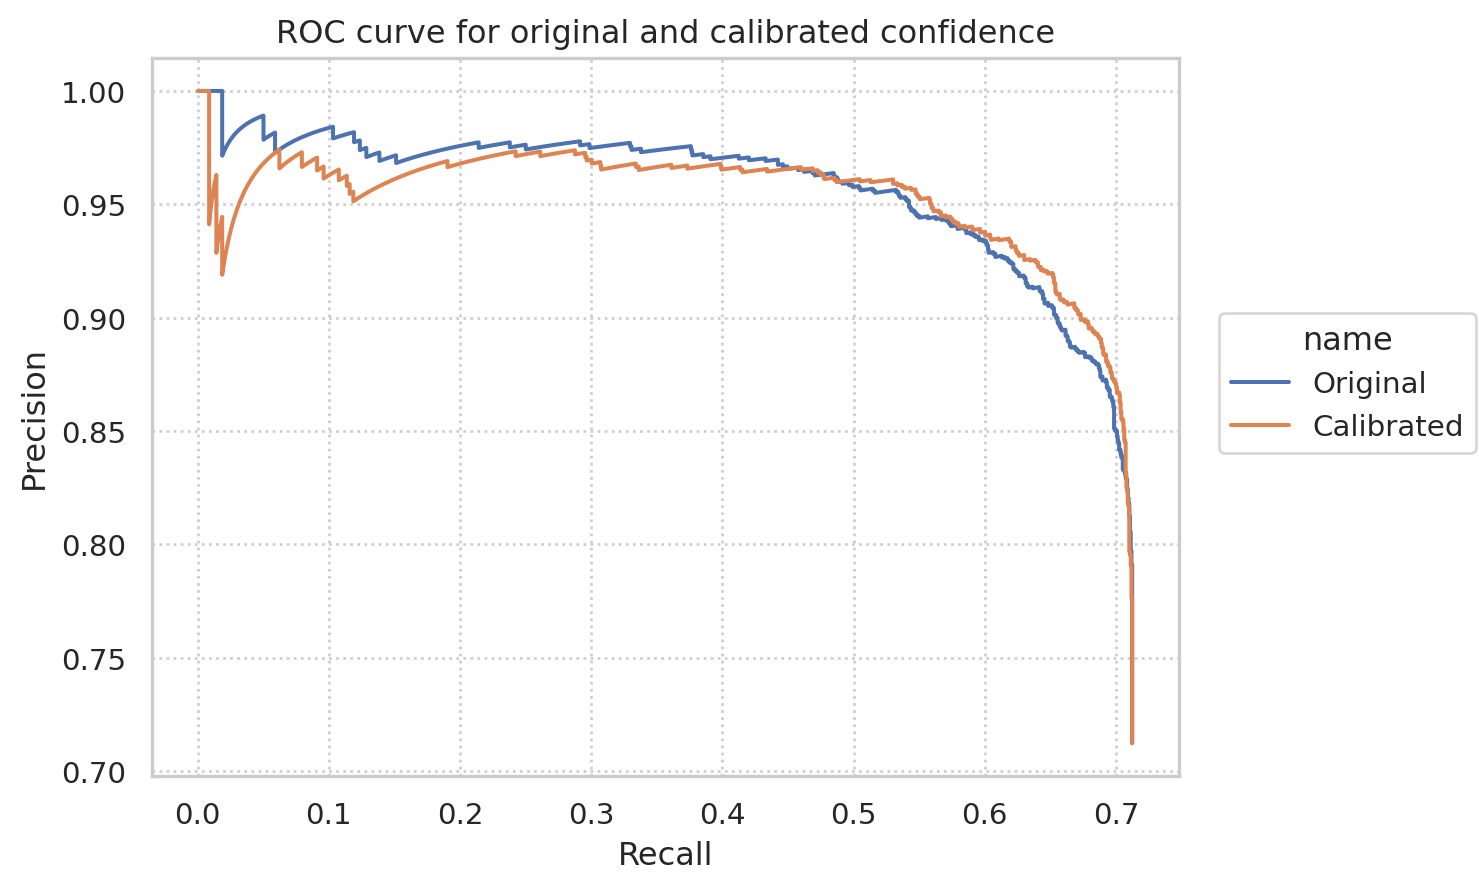

In [22]:
original = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column='confidence',
    label_column='correct',
    name='Original'
)
calibrated = compute_roc_curve(
    input_dataset=test_dataset,
    confidence_column='calibrated_confidence',
    label_column='correct',
    name='Calibrated'
)
metrics = pd.concat([original, calibrated], axis=0).reset_index(drop=True)
metrics['fdr'] = 1 - metrics['precision']

plot = so.Plot(metrics, x='recall', y='precision', color='name')
plot = plot.add(so.Line(), group='name')
plot = plot.theme(theme_dict)
plot = plot.label(y='Precision', x='Recall', title='ROC curve for original and calibrated confidence')
plot

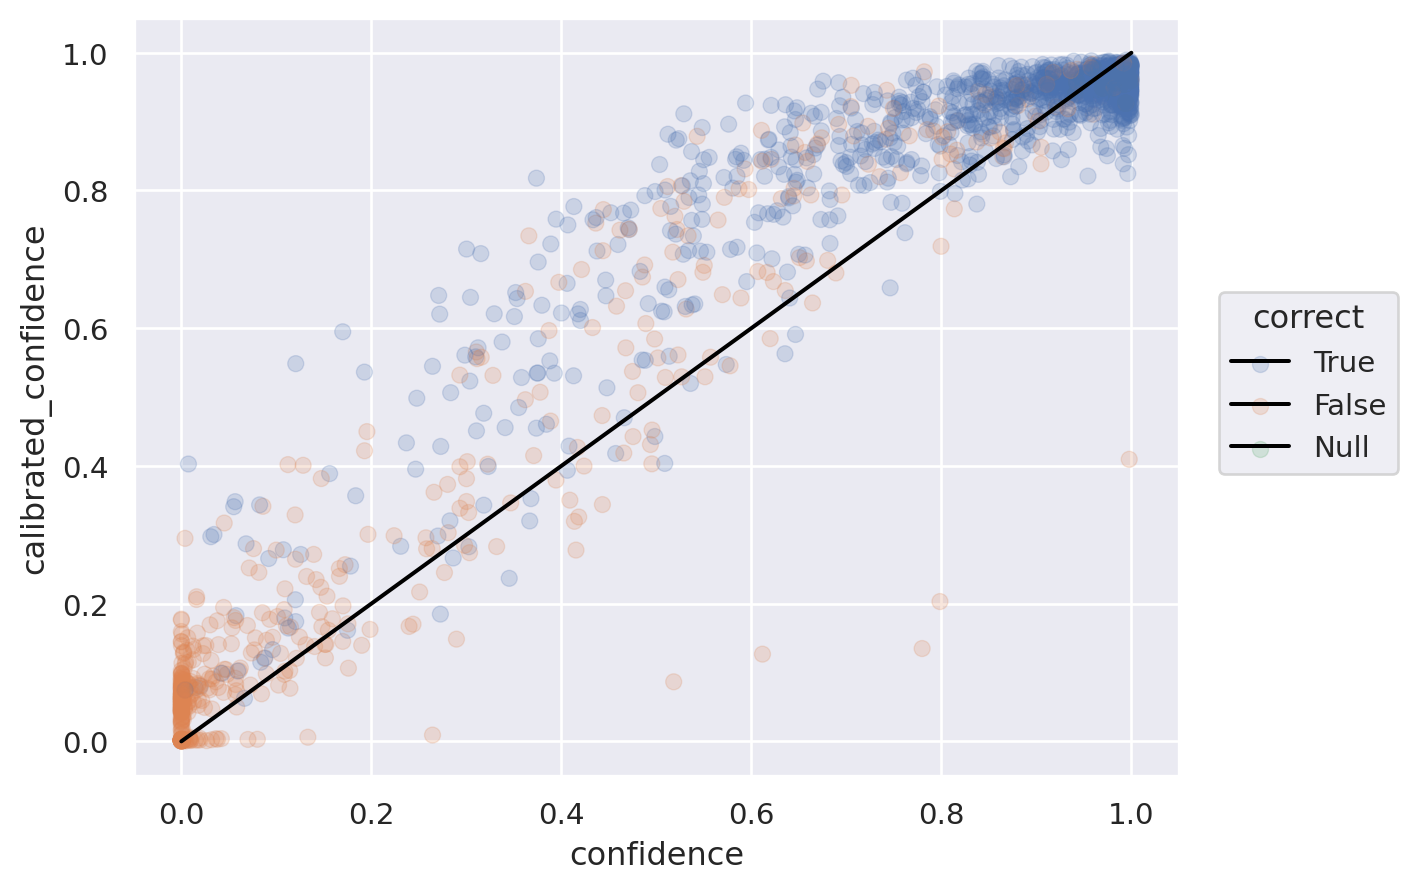

In [23]:
# TODO: quantify confidence shift
data = test_dataset.metadata[['confidence', 'calibrated_confidence', 'correct']].copy(deep=True)
data['correct'] = pd.Categorical(data['correct'])

so.Plot(
    data, x='confidence', y='calibrated_confidence', color='correct'
).add(
    so.Dot(alpha=0.2)
).add(
    so.Line(color='black', linestyle='-'),
    data=pd.DataFrame(
        {'confidence': [0., 1.], 'calibrated_confidence': [0., 1.], 'correct': ['Null', 'Null']}
    )
)

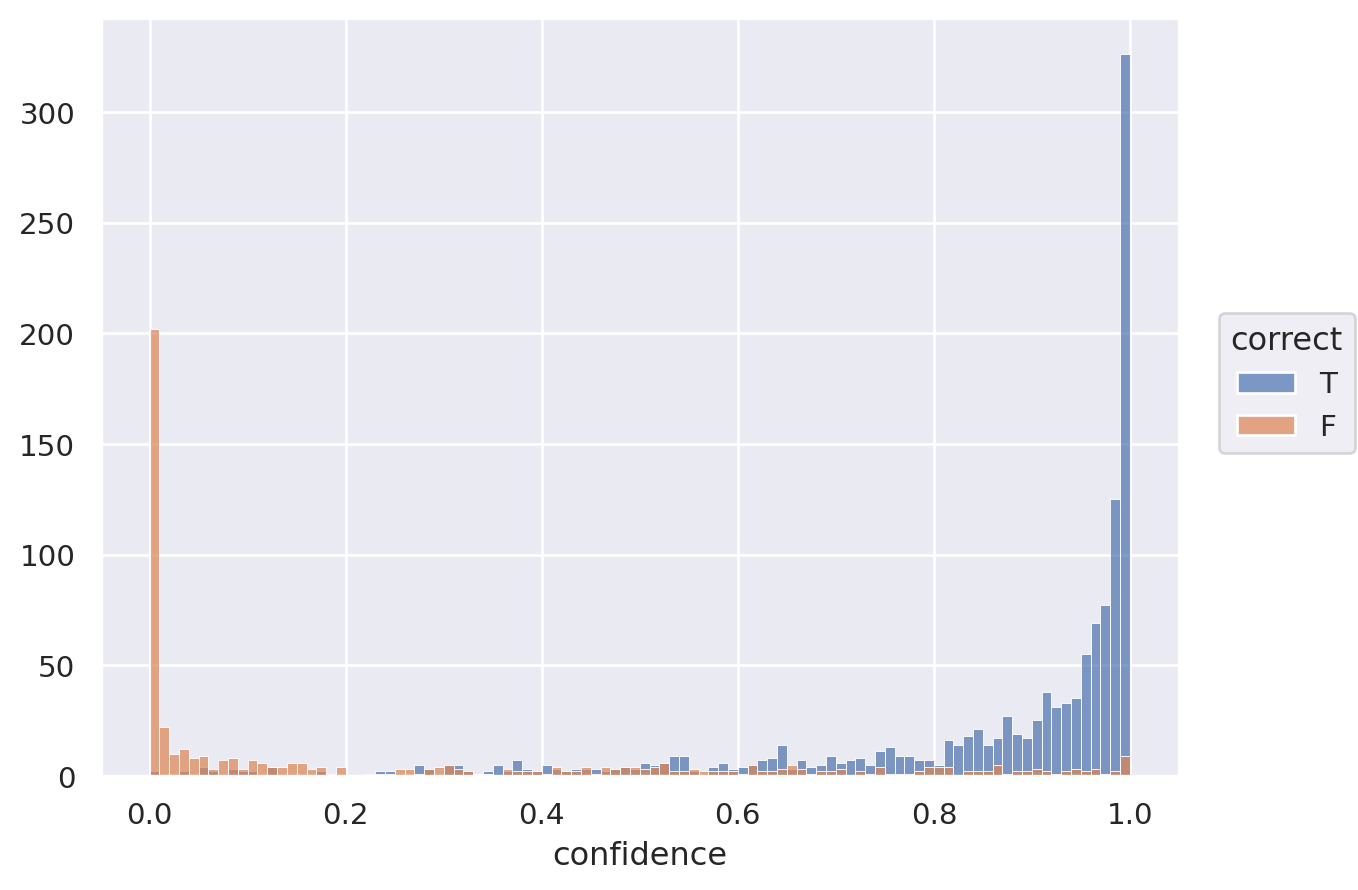

In [24]:
plot_df = test_dataset.metadata[['confidence', 'correct']].copy(deep=True)
plot_df['correct'] = plot_df['correct'].apply(lambda x: 'T' if x else 'F')
so.Plot(
    plot_df, 'confidence'
).add(
    so.Bars(), so.Hist(bins=100), color='correct'
)

In [25]:
plot_df[plot_df['confidence'] < 1e-1]

,confidence,correct
7,0.057608,T
8,0.007328,F
9,0.000004,F
12,0.020088,T
14,0.001083,F
...,...,...
1745,0.002658,F
1757,0.000994,F
1771,0.008941,F
1788,0.000054,F


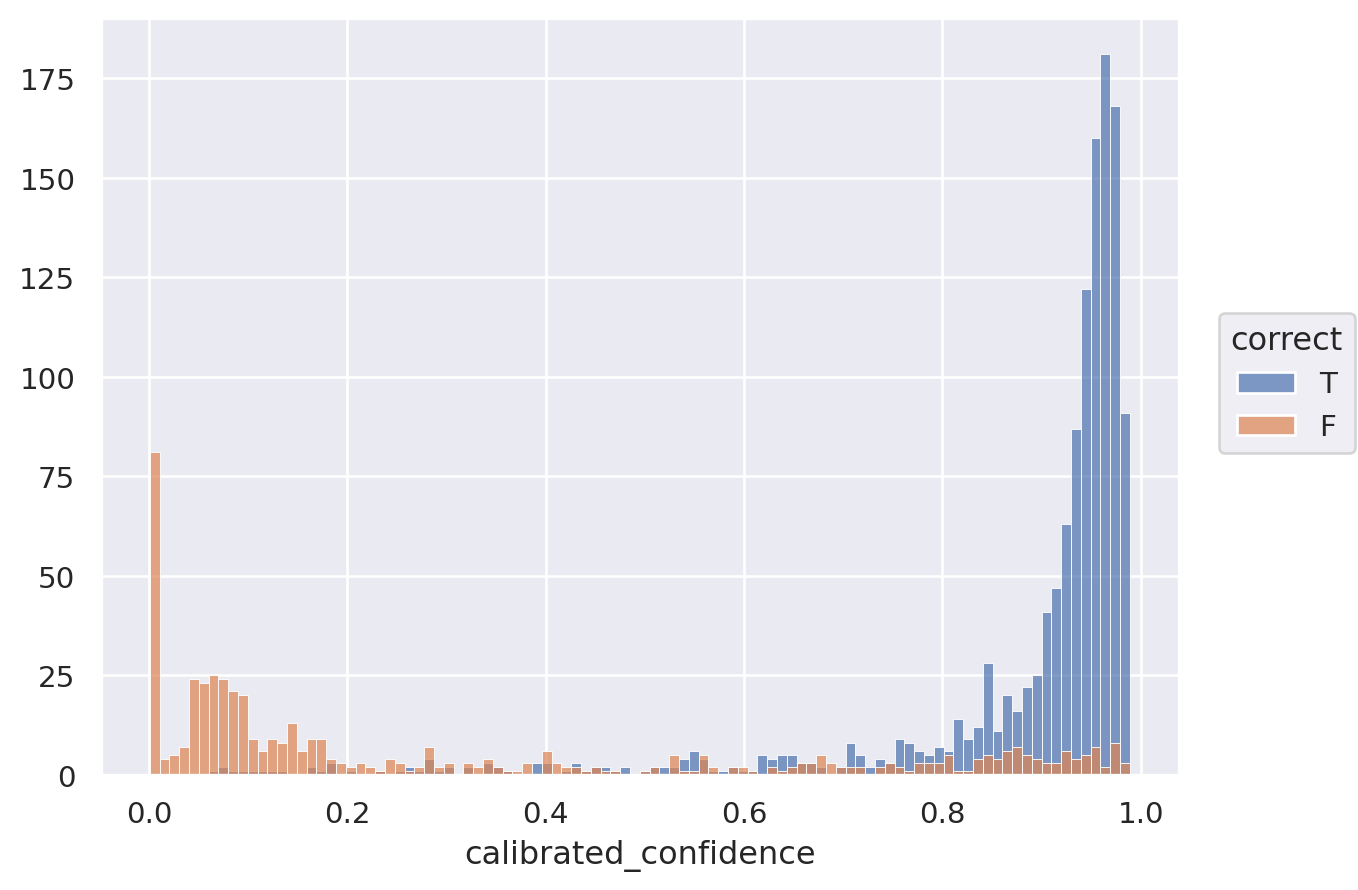

In [26]:
plot_df = test_dataset.metadata[['calibrated_confidence', 'correct']].copy(deep=True)
plot_df['correct'] = plot_df['correct'].apply(lambda x: 'T' if x else 'F')
so.Plot(
    plot_df, 'calibrated_confidence'
).add(
    so.Bars(), so.Hist(bins=100), color='correct'
)

In [27]:
plot_df[plot_df['calibrated_confidence'] < 1e-1]

,calibrated_confidence,correct
9,0.048001,F
12,0.080052,T
14,0.018300,F
18,0.051195,F
37,0.023328,F
...,...,...
1739,0.001108,F
1745,0.066265,F
1757,0.000847,F
1771,0.077974,F


In [28]:
database_grounded_fdr_control = DatabaseGroundedFDRControl()
database_grounded_fdr_control.fit(
    dataset=test_dataset.metadata, residue_masses=RESIDUE_MASSES
)

mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata['confidence'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
100%|██████████| 5000/5000 [00:01<00:00, 4601.46it/s, init loss: -1521.8826, avg. loss [4751-5000]: -2173.5102]


In [29]:
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

Array(0.99951214, dtype=float32)

In [30]:
mixture_fdr_control = EmpiricalBayesFDRControl()
mixture_fdr_control.fit(dataset=test_dataset.metadata['calibrated_confidence'])
mixture_fdr_control.get_confidence_cutoff(threshold=0.05)

100%|██████████| 5000/5000 [00:01<00:00, 4800.84it/s, init loss: -521.3464, avg. loss [4751-5000]: -1433.0880]


Array(0.9915815, dtype=float32)